In [1]:
from lmfit import Parameters
from scipy.integrate import odeint
from lmfit import minimize, report_fit
import numpy as np
import matplotlib.pyplot as plt
import pyenzyme as pe
import pandas as pd

In [2]:
km = 4  # mmole / l 
vmax = 10 # mmole / l*s 

init_sub = [0.5,1,4,30,50,80,160]   # mmole / l
e = 0.05 # mmole / l

In [3]:
params = Parameters()
params.add('vmax', value=vmax, min=0.0001, max=100)
params.add('K_m', value=km, min=0.0001, max=100)

In [4]:
def menten_irreversible(w0: tuple, t, params) -> tuple:
    cS, cE, cP, cI = w0

    vmax = params['vmax'].value
    K_m = params['K_m'].value

    dc_S = -vmax * (cS) / (K_m+cS)
    dc_E = 0
    dc_P = -dc_S
    dc_I = 0

    return (dc_S, dc_E, dc_P, dc_I)

In [5]:
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(menten_irreversible, w0, t, args=(params,))
    return w


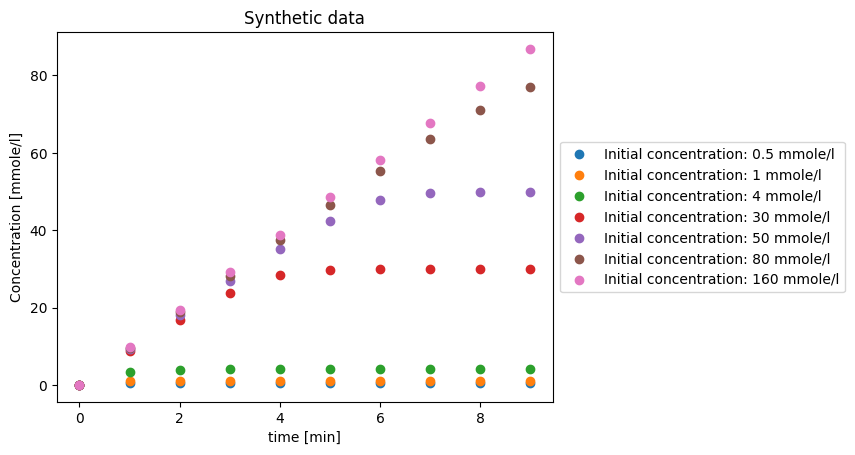

In [6]:
time = np.arange(10)
my_array = np.array([])

for i in range(len(init_sub)):
    cS = init_sub[i]
    cE = e
    cP = 0
    cI = 0
    w0 = cS, cE, cP, cI


    data_fitted = g(time, w0, params=params)
    
    plt.scatter(time, data_fitted[:,2], linewidth=1, label='Initial concentration: ' + str(init_sub[i]) + ' mmole/l')
    my_array = np.append(my_array, data_fitted[:,2])


    plt.ylabel(f"Concentration [mmole/l]")
    plt.xlabel("time [min]")
    plt.title("Synthetic data")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
product_conc = my_array.reshape(len(init_sub), 10)

In [8]:
# Convert product concentration to substrate concentration
substrate_conc = product_conc
for i in range(len(substrate_conc)):
    for j in range(len(substrate_conc[i])):
        substrate_conc[i][j] = np.round(init_sub[i] - substrate_conc[i][j], 3)

In [9]:
np.set_printoptions(precision=3, suppress=True)
substrate_conc

array([[  0.5  ,   0.046,   0.004,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,  -0.   ],
       [  1.   ,   0.103,   0.009,   0.001,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,  -0.   ],
       [  4.   ,   0.741,   0.072,   0.006,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ],
       [ 30.   ,  21.359,  13.264,   6.265,   1.636,   0.193,   0.017,
          0.001,   0.   ,   0.   ],
       [ 50.   ,  40.812,  31.809,  23.09 ,  14.855,   7.558,   2.306,
          0.312,   0.027,   0.002],
       [ 80.   ,  70.505,  61.079,  51.743,  42.528,  33.484,  24.701,
         16.351,   8.82 ,   3.058],
       [160.   , 150.251, 140.519, 130.806, 121.114, 111.447, 101.808,
         92.205,  82.643,  73.132]])

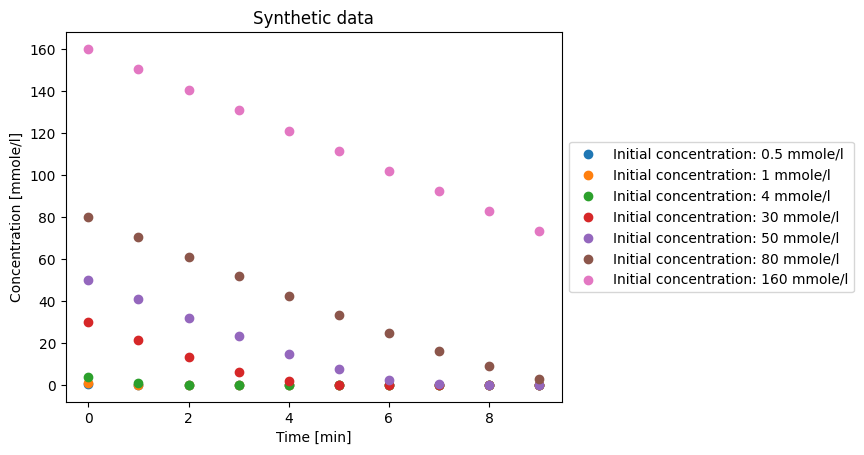

In [10]:
for i in range(len(init_sub)):
    plt.scatter(time, substrate_conc[i], linewidth=1, label='Initial concentration: ' + str(init_sub[i]) + ' mmole/l')
    plt.ylabel(f"Concentration [mmole/l]")
    plt.xlabel("Time [min]")
    plt.title("Synthetic data")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
import pyenzymekinetics as py

In [12]:
fit = py.EnzymeKinetics(time=np.array(time), substrate=substrate_conc, init_substrate=np.array(init_sub), inhibitor=np.array([0]), enzyme=np.array([e]))

[0]


In [13]:
fit.fit_models()

irreversible Michaelis Menten
irreversible Michaelis Menten with enzyme inactivation
kcat/Km
kcat/Km with enzyme inactivation
substrate inhibition
product inhibition
competitive inhibition
competitive inhibition with enzyme inactivation
uncompetitive inhibition
uncompetitive inhibition with enzyme inactivation
non-competitive inhibition
substrate inhibition with enzyme inactivation


mashallah
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 70
    # variables        = 2
    chi-square         = 3.8795e-06
    reduced chi-square = 5.7052e-08
    Akaike info crit   = -1165.58050
    Bayesian info crit = -1161.08351
[[Variables]]
    k_cat:  199.999344 +/- 3.8786e-04 (0.00%) (init = 194.98)
    Km:     3.99997605 +/- 1.0172e-04 (0.00%) (init = 10.88457)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km) = 0.816


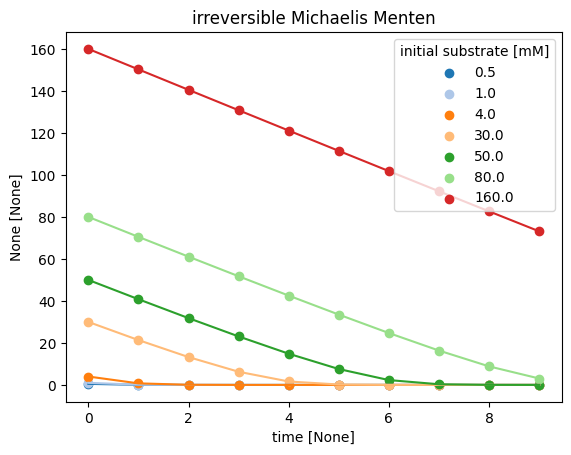

In [14]:
fit.visualize_fit()

# One try with my workflow

In [15]:
def michaelis_menten(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f1 = -vmax * s / (km + s) # S'
    return f1

def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(michaelis_menten, w0, t, args=(params,))
    return w

def residual(params, t, data_s):
    
    ndata = np.shape(data_s)[0] # get dimensions of data (ndata = datasets, nt = measurements in one dataset)
    resid = 0.0 * data_s[:] # initialize the residual vector (data_s[:]-> idiom for making a copy of this list)
    
    # compute residual per data set
    for i in range(ndata):
        w0 = data_s[i][0] # Take the fist measurement of each data set
        
        # params = e.g. Km and vmax
        # t = time of measurements
        model = g(t, w0, params) # solve the ODE with the given parameters
        
        # get modeled substrate
        s_model = model[:,0] # transform the array to just only 1 row
        
        #print(data_s[i][:], s_model)
        # compute distance to measured data 
        resid[i][:]=data_s[i][:]-s_model # data_s[i,:] -> take each data set and substract the calculated ODE results -> get residuals
    
    return resid.flatten() # make a 1-D array (LMfit needs it like that)

def residual_single(params, t, data_s):
    
    w0 = data_s[0] # first value of measurement
    model = g(t, w0, params) # g -> solving ODE 
    
    # only have data for s not v
    s_model = model[:,0] # 0th column
    
    return (s_model - data_s).ravel()

def get_v(time, data_s):
    
    v_all = 0.0*data_s[:] # initialize velocity vector
    
    if len(data_s.shape)>1: # instead of len(data_s.shape) because Abfrage sonst falsch
        
        for i in range(data_s.shape[0]):
            
            prev_value = data_s[i,0]
            prev_time = 0.0
            
            for j in range(data_s.shape[1]):
                
                if time[j] == 0:
                    delta = prev_value - data_s[i,j]
                else:
                    delta = abs( (prev_value - data_s[i,j])/(time[j]-prev_time))
                
                v_all[i,j] = delta
                prev_value = data_s[i,j]
                prev_time = time[j]
                
        v = np.max(v_all, axis=0)
        
    else:
        
        prev_value = data_s[0]
        prev_time = 0.0
        
        for j in range(data_s.shape[0]):
            
            if time[j] == 0:
                delta = prev_value - data_s[j]
            else:
                delta = abs( (prev_value - data_s[j])/(time[j]-prev_time))
            
            v_all[j] = delta
            prev_value = data_s[j]
            prev_time = time[j]
            
        v = v_all
        
    return v

def get_initial_vmax(time, data_s):
    v = get_v(time,data_s)
    return np.max(v)

def get_initial_Km(time, data_s):
    
    v = get_v(time,data_s)
    
    idx_max = np.where(v == np.max(v))[0][0]
    idx_Km = (np.abs(v[idx_max:]-np.max(v)/2)).argmin()
    
    if len(data_s.shape)>1:
        km = np.mean(data_s,axis=0)[idx_max+idx_Km]
    else:
        km = data_s[idx_max+idx_Km]
    
    return km

def init_params(data_s, data_time):
    # time
    #t_measured = data_time

    # initial conditions:
    if len(data_s.shape)>1: # pick the first measurement of data_s, if multidimensional array then first prep the array
        s0 = np.max(data_s,axis=0)[0]
    else:
        s0 = data_s[0] # pick the first measurement of data_s

    # Set parameters including bounds
    vmax = get_initial_vmax(data_time, data_s)
    km = get_initial_Km(data_time, data_s)

    params = Parameters()
    params.add('vmax', value=vmax, min=0.0001, max=100.) # max = Wie am besten wählen?
    params.add('Km', value=km, min=0.01, max=s0) 
    return params

def modeling(data_s, t_measured, params):
    if np.shape(data_s)[0]>1:
        result = minimize(residual , params, args=(t_measured, data_s), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        for i in range(data_s.shape[0]):
            plt.plot(t_measured, data_s[i, :], 'o')
            #w0 = params['v0'].value, data_s[i,0]
            w0 = data_s[i,0]
            data_fitted = g(t_measured, w0, result.params)
            plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()
    
    else:
        result = minimize(residual_single , params, args=(t_measured, data_s), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        plt.plot(t_measured, data_s[:], 'o')
        w0 = data_s[0]
        data_fitted = g(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()

In [16]:
substrate_conc

array([[  0.5  ,   0.046,   0.004,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,  -0.   ],
       [  1.   ,   0.103,   0.009,   0.001,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,  -0.   ],
       [  4.   ,   0.741,   0.072,   0.006,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ],
       [ 30.   ,  21.359,  13.264,   6.265,   1.636,   0.193,   0.017,
          0.001,   0.   ,   0.   ],
       [ 50.   ,  40.812,  31.809,  23.09 ,  14.855,   7.558,   2.306,
          0.312,   0.027,   0.002],
       [ 80.   ,  70.505,  61.079,  51.743,  42.528,  33.484,  24.701,
         16.351,   8.82 ,   3.058],
       [160.   , 150.251, 140.519, 130.806, 121.114, 111.447, 101.808,
         92.205,  82.643,  73.132]])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 70
    # variables        = 2
    chi-square         = 3.8787e-06
    reduced chi-square = 5.7039e-08
    Akaike info crit   = -1165.59572
    Bayesian info crit = -1161.09873
[[Variables]]
    vmax:  9.99996833 +/- 1.9396e-05 (0.00%) (init = 9.749)
    Km:    3.99997777 +/- 1.0173e-04 (0.00%) (init = 10.88457)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.816


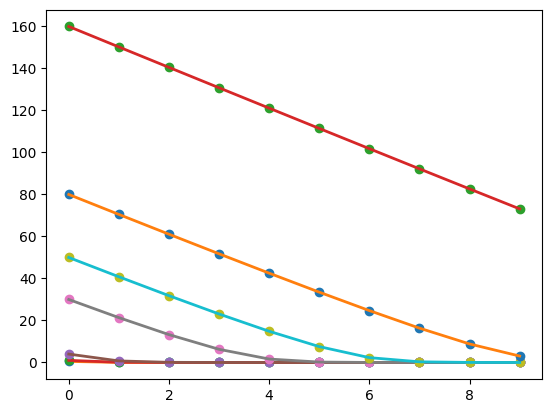

In [17]:
params_test = init_params(substrate_conc, time)
modeling(substrate_conc, time, params_test)

# Create EnzymeML Document

In [18]:
import pyenzyme as pe

In [19]:
init_sub

[0.5, 1, 4, 30, 50, 80, 160]

In [20]:
enzmldoc = pe.EnzymeMLDocument(name = "synthetic_data")

author = pe.Creator(
    given_name="Benjamin", family_name="Hadzovic",
    mail="hadzovic.benjamin@gmail.com")

author_id = enzmldoc.addCreator(author)

# Create a vessel and add it to the document
vessel = pe.Vessel(name="Falcon Tube", volume=10.0, unit="ml")
vessel_id = enzmldoc.addVessel(vessel)

# Set up reactants and proteins from databases
enzyme = pe.Protein(name="Enzyme", vessel_id=vessel_id)
enzyme_id = enzmldoc.addProtein(enzyme)

substrate = pe.Reactant(name="Substrate", vessel_id=vessel_id, unit="mmole / l")
substrate_id = enzmldoc.addReactant(substrate)

product = pe.Reactant(name="Product", vessel_id=vessel_id, unit="mmole / l")
product_id = enzmldoc.addReactant(product)


# Build the reaction
reaction = pe.EnzymeReaction.fromEquation(
    equation="Substrate -> Product",
    ph=7.4,
    temperature=37,
    temperature_unit="C",
    modifiers=[enzyme_id],
    name="Example Reaction",
    enzmldoc=enzmldoc
)

reaction.addEduct(species_id=substrate_id, stoichiometry=1.0, enzmldoc=enzmldoc)
reaction.addProduct(species_id=product_id, stoichiometry=1.0, enzmldoc=enzmldoc)

# ... and add it to the document
reaction_id = enzmldoc.addReaction(reaction)

# First Measurement
measurement_1 = pe.Measurement(name="Substrate measurement 1")

# Add each entity that will be measured
measurement_1.addData(reactant_id=substrate_id, init_conc=init_sub[0], unit="mmole / l")
measurement_1.addData(reactant_id=product_id, unit="mmole / l")
measurement_1.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")

# Add it to the EnzymeML document
meas_1_id = enzmldoc.addMeasurement(measurement_1)

measurement_2 = pe.Measurement(name="Substrate measurement 2")

# Add each entity that will be measured
measurement_2.addData(reactant_id=substrate_id, init_conc=init_sub[1], unit="mmole / l")
measurement_2.addData(reactant_id=product_id, unit="mmole / l")
measurement_2.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")

# Add it to the EnzymeML document
meas_2_id = enzmldoc.addMeasurement(measurement_2)

# Measurement 3
measurement_3 = pe.Measurement(name="Substrate measurement 3")

measurement_3.addData(reactant_id=substrate_id, init_conc=init_sub[2], unit="mmole / l")
measurement_3.addData(reactant_id=product_id, unit="mmole / l")
measurement_3.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_3_id = enzmldoc.addMeasurement(measurement_3)

# Measurement 4
measurement_4 = pe.Measurement(name="Substrate measurement 4")

measurement_4.addData(reactant_id=substrate_id, init_conc=init_sub[3], unit="mmole / l")
measurement_4.addData(reactant_id=product_id, unit="mmole / l")
measurement_4.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_4_id = enzmldoc.addMeasurement(measurement_4)

# Measurement 5
measurement_5 = pe.Measurement(name="Substrate measurement 5")

measurement_5.addData(reactant_id=substrate_id, init_conc=init_sub[4], unit="mmole / l")
measurement_5.addData(reactant_id=product_id, unit="mmole / l")
measurement_5.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_5_id = enzmldoc.addMeasurement(measurement_5)

# Measurement 6
measurement_6 = pe.Measurement(name="Substrate measurement 6")

measurement_6.addData(reactant_id=substrate_id, init_conc=init_sub[5], unit="mmole / l")
measurement_6.addData(reactant_id=product_id, unit="mmole / l")
measurement_6.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_6_id = enzmldoc.addMeasurement(measurement_6)

# Measurement 7
measurement_7 = pe.Measurement(name="Substrate measurement 7")

measurement_7.addData(reactant_id=substrate_id, init_conc=init_sub[6], unit="mmole / l")
measurement_7.addData(reactant_id=product_id, unit="mmole / l")
measurement_7.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_7_id = enzmldoc.addMeasurement(measurement_7)


# Adding raw data 
repl_substrate_1 = pe.Replicate(
    id="repl_substrate_1",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[0].tolist()
)

# Add it to the first measurement
meas = enzmldoc.getMeasurement(meas_1_id)
meas.addReplicates([repl_substrate_1], enzmldoc=enzmldoc)


# Raw data measurement 2
repl_substrate_2 = pe.Replicate(
    id="repl_substrate_2",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[1].tolist()
)

meas = enzmldoc.getMeasurement(meas_2_id)
meas.addReplicates([repl_substrate_2], enzmldoc=enzmldoc)


# Raw data measurement 3
repl_substrate_3 = pe.Replicate(
    id="repl_substrate_3",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[2].tolist()
)

meas = enzmldoc.getMeasurement(meas_3_id)
meas.addReplicates([repl_substrate_3], enzmldoc=enzmldoc)

# Raw data measurement 4
repl_substrate_4 = pe.Replicate(
    id="repl_substrate_4",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[3].tolist()
)

meas = enzmldoc.getMeasurement(meas_4_id)
meas.addReplicates([repl_substrate_4], enzmldoc=enzmldoc)

# Raw data measurement 5
repl_substrate_5 = pe.Replicate(
    id="repl_substrate_5",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[4].tolist()
)

meas = enzmldoc.getMeasurement(meas_5_id)
meas.addReplicates([repl_substrate_5], enzmldoc=enzmldoc)


# Raw data measurement 6
repl_substrate_6 = pe.Replicate(
    id="repl_substrate_6",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[5].tolist()
)

meas = enzmldoc.getMeasurement(meas_6_id)
meas.addReplicates([repl_substrate_6], enzmldoc=enzmldoc)


# Raw data measurement 7
repl_substrate_7 = pe.Replicate(
    id="repl_substrate_7",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[6].tolist()
)

meas = enzmldoc.getMeasurement(meas_7_id)
meas.addReplicates([repl_substrate_7], enzmldoc=enzmldoc)

# Adding the Model
model_generator = pe.KineticModel.createGenerator(
    name= "irreversible Michaelis-Menten",
    equation= "vmax * substrate / (Km + substrate)",
    vmax={"unit": "mmole / l * s"}, 
    Km={"unit": "mmole / l"},
)

model = model_generator(substrate=substrate_id)
print("Model: ", model.equation)

reaction.model = model

# To an OMEX archive
enzmldoc.toFile(".", name="synthetic_data")

Model:  vmax * 's0' / (Km + 's0')

Archive was written to ./synthetic_data.omex



In [21]:
my_omex = pe.EnzymeMLDocument.fromFile("./synthetic_data.omex")

reaction_omex = my_omex.reaction_dict
reactant_omex = my_omex.reactant_dict

# For some reason two educts and products are added, so delete them
del reaction_omex['r0'].educts[1]
del reaction_omex['r0'].products[1]

# For some reason there is no unit, so add them
reactant_omex['s0'].unit = "mmole / l"
reactant_omex['s1'].unit = "mmole / l"

my_omex.toFile(".", name="synthetic_data")


Archive was written to ./synthetic_data.omex



In [22]:
enzmldoc.toFile(".", name="name_of_document")


Archive was written to ./name_of_document.omex



In [23]:
enzmldoc.printDocument()

synthetic_data
>>> Reactants
	ID: s0 	 Name: Substrate
	ID: s1 	 Name: Product
>>> Proteins
	ID: p0 	 Name: Enzyme
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Example Reaction


# Model with Pysces to see if results are good

In [24]:
from pyenzyme.thinlayers import ThinLayerPysces

In [25]:
enzmldoc = pe.EnzymeMLDocument.fromFile("./synthetic_data.omex")

In [26]:
# In addition, generate a blank YAML file to manually enter initial values for modeling
#enzmldoc.generateInitialValueTemplate()

In [27]:
enzmldoc.applyModelInitialization("/Users/benjamin/Masterarbeit/Radde/EnzymeMLtoPeTAB/synthetic_data/synthetic_data_init_values.yaml", to_values=True)
enzmldoc.exportKineticParameters()


,name,value,unit,initial_value,upper,lower,is_global,stdev,constant
reaction,,,,,,,,,
r0,vmax,15.0,mmole / l s,15.0,150.0,0.010,False,None,False
r0,Km,10.0,mmole / l,10.0,40.0,0.001,False,None,False


In [28]:
# Initialize the layer
tl_pysces = ThinLayerPysces(
    "synthetic_data.omex", init_file="synthetic_data_init_values.yaml",
    model_dir="pySCeS"
)

Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.3) with SciPy (1.9.1)
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /Users/benjamin/Pysces/psc
pysces.output_dir = /Users/benjamin/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.2) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with: doi:10.1093/bio

In [29]:
# Run optimization
tl_opt = tl_pysces.optimize()

In [30]:
tl_opt

Creating EnzymeML documents below Km and above 

In [31]:
enzmldoc = pe.EnzymeMLDocument(name = "synthetic_data_below_Km")

author = pe.Creator(
    given_name="Benjamin", family_name="Hadzovic",
    mail="hadzovic.benjamin@gmail.com")

author_id = enzmldoc.addCreator(author)

# Create a vessel and add it to the document
vessel = pe.Vessel(name="Falcon Tube", volume=10.0, unit="ml")
vessel_id = enzmldoc.addVessel(vessel)

# Set up reactants and proteins from databases
enzyme = pe.Protein(name="Enzyme", vessel_id=vessel_id)
enzyme_id = enzmldoc.addProtein(enzyme)

substrate = pe.Reactant(name="Substrate", vessel_id=vessel_id, unit="mmole / l")
substrate_id = enzmldoc.addReactant(substrate)

product = pe.Reactant(name="Product", vessel_id=vessel_id, unit="mmole / l")
product_id = enzmldoc.addReactant(product)


# Build the reaction
reaction = pe.EnzymeReaction.fromEquation(
    equation="Substrate -> Product",
    ph=7.4,
    temperature=37,
    temperature_unit="C",
    modifiers=[enzyme_id],
    name="Example Reaction",
    enzmldoc=enzmldoc
)

reaction.addEduct(species_id=substrate_id, stoichiometry=1.0, enzmldoc=enzmldoc)
reaction.addProduct(species_id=product_id, stoichiometry=1.0, enzmldoc=enzmldoc)

# ... and add it to the document
reaction_id = enzmldoc.addReaction(reaction)

# First Measurement
measurement_1 = pe.Measurement(name="Substrate measurement 1")

# Add each entity that will be measured
measurement_1.addData(reactant_id=substrate_id, init_conc=init_sub[0], unit="mmole / l")
measurement_1.addData(reactant_id=product_id, unit="mmole / l")
measurement_1.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")

# Add it to the EnzymeML document
meas_1_id = enzmldoc.addMeasurement(measurement_1)

measurement_2 = pe.Measurement(name="Substrate measurement 2")

# Add each entity that will be measured
measurement_2.addData(reactant_id=substrate_id, init_conc=init_sub[1], unit="mmole / l")
measurement_2.addData(reactant_id=product_id, unit="mmole / l")
measurement_2.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")

# Add it to the EnzymeML document
meas_2_id = enzmldoc.addMeasurement(measurement_2)

# Adding raw data 
repl_substrate_1 = pe.Replicate(
    id="repl_substrate_1",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[0].tolist()
)

# Add it to the first measurement
meas = enzmldoc.getMeasurement(meas_1_id)
meas.addReplicates([repl_substrate_1], enzmldoc=enzmldoc)


# Raw data measurement 2
repl_substrate_2 = pe.Replicate(
    id="repl_substrate_2",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[1].tolist()
)

meas = enzmldoc.getMeasurement(meas_2_id)
meas.addReplicates([repl_substrate_2], enzmldoc=enzmldoc)

# Adding the Model

model_generator = pe.KineticModel.createGenerator(
    name= "irreversible Michaelis-Menten",
    equation= "vmax * substrate / (Km + substrate)",
    vmax={"unit": "mmole / l * s"}, 
    Km={"unit": "mmole / l"},
)

model = model_generator(substrate=substrate_id)
print("Model: ", model.equation)

reaction.model = model

# To an OMEX archive
enzmldoc.toFile(".", name="synthetic_data_below_Km")

Model:  vmax * 's0' / (Km + 's0')

Archive was written to ./synthetic_data_below_Km.omex



Creating Omex above Km

In [32]:
enzmldoc = pe.EnzymeMLDocument(name = "synthetic_data_above_Km")

author = pe.Creator(
    given_name="Benjamin", family_name="Hadzovic",
    mail="hadzovic.benjamin@gmail.com")

author_id = enzmldoc.addCreator(author)

# Create a vessel and add it to the document
vessel = pe.Vessel(name="Falcon Tube", volume=10.0, unit="ml")
vessel_id = enzmldoc.addVessel(vessel)

# Set up reactants and proteins from databases
enzyme = pe.Protein(name="Enzyme", vessel_id=vessel_id)
enzyme_id = enzmldoc.addProtein(enzyme)

substrate = pe.Reactant(name="Substrate", vessel_id=vessel_id, unit="mmole / l")
substrate_id = enzmldoc.addReactant(substrate)

product = pe.Reactant(name="Product", vessel_id=vessel_id, unit="mmole / l")
product_id = enzmldoc.addReactant(product)


# Build the reaction
reaction = pe.EnzymeReaction.fromEquation(
    equation="Substrate -> Product",
    ph=7.4,
    temperature=37,
    temperature_unit="C",
    modifiers=[enzyme_id],
    name="Example Reaction",
    enzmldoc=enzmldoc
)

reaction.addEduct(species_id=substrate_id, stoichiometry=1.0, enzmldoc=enzmldoc)
reaction.addProduct(species_id=product_id, stoichiometry=1.0, enzmldoc=enzmldoc)

# ... and add it to the document
reaction_id = enzmldoc.addReaction(reaction)

# Measurement 5
measurement_5 = pe.Measurement(name="Substrate measurement 5")

measurement_5.addData(reactant_id=substrate_id, init_conc=init_sub[4], unit="mmole / l")
measurement_5.addData(reactant_id=product_id, unit="mmole / l")
measurement_5.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_5_id = enzmldoc.addMeasurement(measurement_5)

# Measurement 6
measurement_6 = pe.Measurement(name="Substrate measurement 6")

measurement_6.addData(reactant_id=substrate_id, init_conc=init_sub[5], unit="mmole / l")
measurement_6.addData(reactant_id=product_id, unit="mmole / l")
measurement_6.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_6_id = enzmldoc.addMeasurement(measurement_6)

# Measurement 7
measurement_7 = pe.Measurement(name="Substrate measurement 7")

measurement_7.addData(reactant_id=substrate_id, init_conc=init_sub[6], unit="mmole / l")
measurement_7.addData(reactant_id=product_id, unit="mmole / l")
measurement_7.addData(protein_id=enzyme_id, init_conc=e, unit="mmole / l")
meas_7_id = enzmldoc.addMeasurement(measurement_7)

# Raw data measurement 5
repl_substrate_5 = pe.Replicate(
    id="repl_substrate_5",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[4].tolist()
)

meas = enzmldoc.getMeasurement(meas_5_id)
meas.addReplicates([repl_substrate_5], enzmldoc=enzmldoc)


# Raw data measurement 6
repl_substrate_6 = pe.Replicate(
    id="repl_substrate_6",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[5].tolist()
)

meas = enzmldoc.getMeasurement(meas_6_id)
meas.addReplicates([repl_substrate_6], enzmldoc=enzmldoc)


# Raw data measurement 7
repl_substrate_7 = pe.Replicate(
    id="repl_substrate_7",
    species_id=substrate_id,
    data_unit="mmole / l",
    time_unit="min",
    time=time.tolist(),
    data=substrate_conc[6].tolist()
)

meas = enzmldoc.getMeasurement(meas_7_id)
meas.addReplicates([repl_substrate_7], enzmldoc=enzmldoc)

# Adding the Model

model_generator = pe.KineticModel.createGenerator(
    name= "irreversible Michaelis-Menten",
    equation= "vmax * substrate / (Km + substrate)",
    vmax={"unit": "mmole / l * s"}, 
    Km={"unit": "mmole / l"},
)

model = model_generator(substrate=substrate_id)
print("Model: ", model.equation)

reaction.model = model

# To an OMEX archive
enzmldoc.toFile(".", name="synthetic_data_above_Km")

Model:  vmax * 's0' / (Km + 's0')

Archive was written to ./synthetic_data_above_Km.omex

